In [1]:
# import statements
from pyspark.sql import SQLContext
from pyspark.sql import Row
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
# Set up SQL Context
sqlContext = SQLContext(sc)

# Shelter Animal Outcomes
## Kaggle Competition

### Load Data

In [2]:
data = (sc.textFile("train.csv")
          .map(lambda line: line.split(",")))
header = data.filter(lambda row: row[0] == "AnimalID").collect()[0]

rows = data.filter(lambda row: row[0] != "AnimalID")
rows.cache()

print ("Header:")
print (header)
print ("Rows:")
print (rows.take(5))

Header:
[u'AnimalID', u'Name', u'DateTime', u'OutcomeType', u'OutcomeSubtype', u'AnimalType', u'SexuponOutcome', u'AgeuponOutcome', u'Breed', u'Color']
Rows:
[[u'A671945', u'Hambone', u'2014-02-12 18:22:00', u'Return_to_owner', u'', u'Dog', u'Neutered Male', u'1 year', u'Shetland Sheepdog Mix', u'Brown/White'], [u'A656520', u'Emily', u'2013-10-13 12:44:00', u'Euthanasia', u'Suffering', u'Cat', u'Spayed Female', u'1 year', u'Domestic Shorthair Mix', u'Cream Tabby'], [u'A686464', u'Pearce', u'2015-01-31 12:28:00', u'Adoption', u'Foster', u'Dog', u'Neutered Male', u'2 years', u'Pit Bull Mix', u'Blue/White'], [u'A683430', u'', u'2014-07-11 19:09:00', u'Transfer', u'Partner', u'Cat', u'Intact Male', u'3 weeks', u'Domestic Shorthair Mix', u'Blue Cream'], [u'A667013', u'', u'2013-11-15 12:52:00', u'Transfer', u'Partner', u'Dog', u'Neutered Male', u'2 years', u'Lhasa Apso/Miniature Poodle', u'Tan']]


In [3]:
df = rows.toDF(header).cache();

In [4]:
df.show(5)

+--------+-------+-------------------+---------------+--------------+----------+--------------+--------------+--------------------+-----------+
|AnimalID|   Name|           DateTime|    OutcomeType|OutcomeSubtype|AnimalType|SexuponOutcome|AgeuponOutcome|               Breed|      Color|
+--------+-------+-------------------+---------------+--------------+----------+--------------+--------------+--------------------+-----------+
| A671945|Hambone|2014-02-12 18:22:00|Return_to_owner|              |       Dog| Neutered Male|        1 year|Shetland Sheepdog...|Brown/White|
| A656520|  Emily|2013-10-13 12:44:00|     Euthanasia|     Suffering|       Cat| Spayed Female|        1 year|Domestic Shorthai...|Cream Tabby|
| A686464| Pearce|2015-01-31 12:28:00|       Adoption|        Foster|       Dog| Neutered Male|       2 years|        Pit Bull Mix| Blue/White|
| A683430|       |2014-07-11 19:09:00|       Transfer|       Partner|       Cat|   Intact Male|       3 weeks|Domestic Shorthai...| Blue

In [5]:
# get SQLContext & register df as Table
df.registerTempTable('Animals')

### Data Exploration
#### Reuseable Functions

In [6]:
def wordcloud_from_frequencies(freq):
    wcFull = WordCloud(max_font_size=40, relative_scaling=.5)
    wcFull.generate_from_frequencies(freq)
    plt.figure(figsize=(10,8))
    plt.imshow(wcFull)
    plt.axis('off')
    plt.show()
    
def sql_to_pandas(sql_query):
    dataframe = sqlContext.sql(sql_query)
    return dataframe.toPandas()

def key_values_to_bar(kv_pairs):
    D = dict(kv_pairs)
    # below from http://stackoverflow.com/questions/16010869/python-plot-a-bar-using-matplotlib-using-a-dictionary
    plt.figure()
    plt.bar(range(len(D)), D.values(), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()


#### Constant Values

In [7]:
COUNT = df.count()
print "COUNT: " + str(COUNT)
OUTCOME = 3
ANIMAL_TYPE = 5
AGE = 7
BREED = 8
COLOUR = 9

COUNT: 26729


### Outcome Frequency

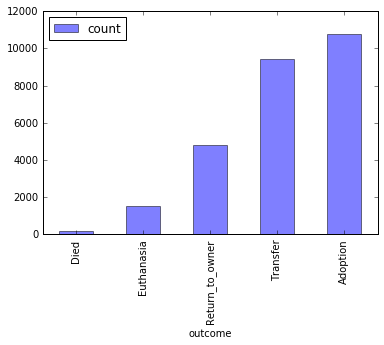

In [8]:
(sql_to_pandas("SELECT OutcomeType as outcome, count(*) as count " + 
               "FROM Animals GROUP BY OutcomeType ORDER BY count(*)")
                 .plot(x='outcome', y='count', kind='bar', alpha=0.5))

### Euthanised Count by Animal Type

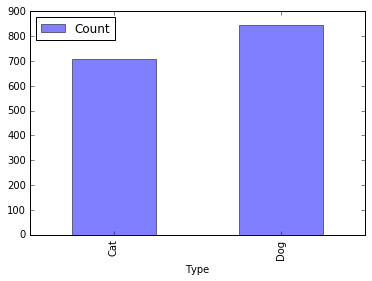

In [9]:
(sql_to_pandas("SELECT AnimalType as Type, count(*) as Count " + 
               "FROM Animals WHERE OutcomeType='Euthanasia' GROUP BY AnimalType ORDER BY count(*)")
                 .plot(x='Type', y='Count', kind='bar', alpha=0.5))

### Euthanised Count by Dog Breed

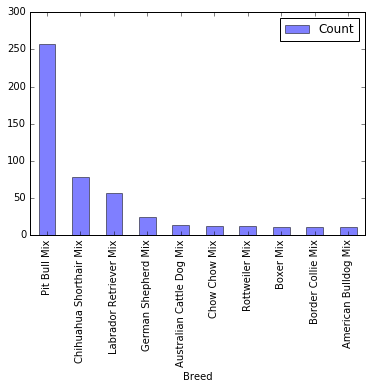

In [10]:
(sql_to_pandas("SELECT Breed, count(*) as Count " + 
               "FROM Animals WHERE OutcomeType='Euthanasia' AND AnimalType='Dog' " + 
               "GROUP BY Breed ORDER BY count(*) DESC LIMIT 10")
                 .plot(x='Breed', y='Count', kind='bar', alpha=0.5))

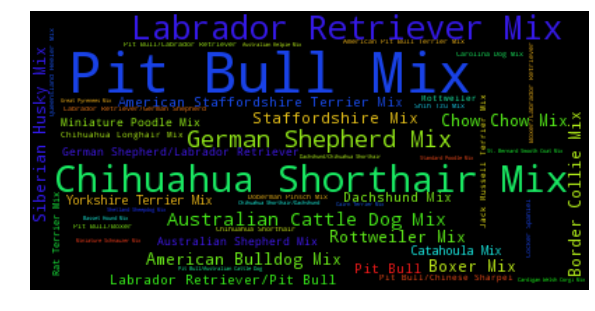

In [11]:

freq = (rows
        .filter(lambda row: row[OUTCOME] == "Euthanasia" and row[ANIMAL_TYPE] == "Dog")
        .map(lambda row: (row[BREED], 1))
        .reduceByKey(lambda a,b: a + b)
        .map(lambda (k,v): (k,(float(v)/float(COUNT))))).collect()
wordcloud_from_frequencies(freq)

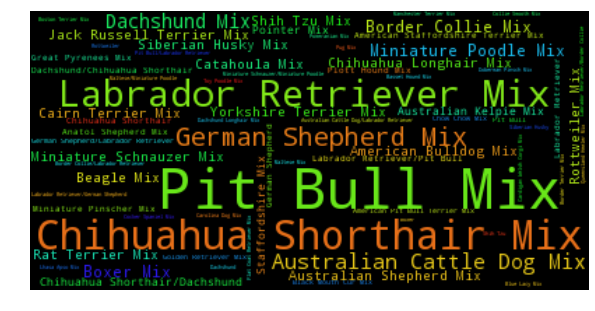

In [12]:
freq = (rows
        .filter(lambda row: row[ANIMAL_TYPE] == "Dog")
        .map(lambda row: (row[BREED], 1))
        .reduceByKey(lambda a,b: a + b)
        .map(lambda (k,v): (k,(float(v)/float(COUNT))))).collect()
wordcloud_from_frequencies(freq)

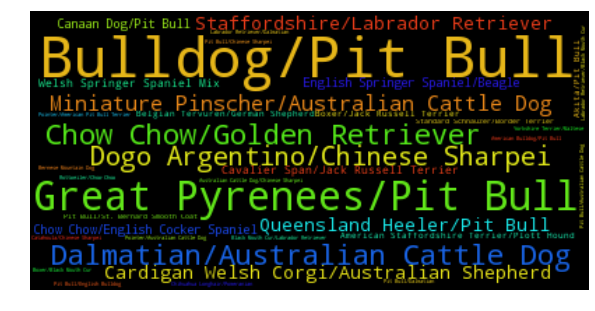

In [13]:
def euthaniased(row):
    if (row[OUTCOME] == 'Euthanasia'):
        return 1;
    else:
        return 0;

ratios = (rows
          .filter(lambda row: row[ANIMAL_TYPE] == "Dog")
          .map(lambda row: ((row[BREED]), (euthaniased(row),1)))
          .reduceByKey(lambda a,b: (a[0] + b[0], a[1] + b[1]))
          .map( lambda (k,v): (k, ( float(v[0])/float(v[1]) ) ) )
          .sortBy(lambda (k,v): -v)
         ).collect()
wordcloud_from_frequencies(ratios)



### Euthanised Count by Cat Breed

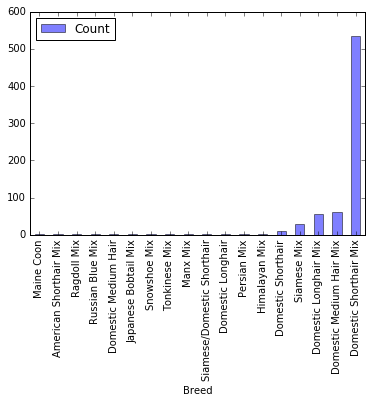

In [14]:
(sql_to_pandas("SELECT Breed, count(*) as Count " + 
               "FROM Animals WHERE OutcomeType='Euthanasia' AND AnimalType='Cat' " + 
               "GROUP BY Breed ORDER BY count(*)")
                 .plot(x='Breed', y='Count', kind='bar', alpha=0.5))

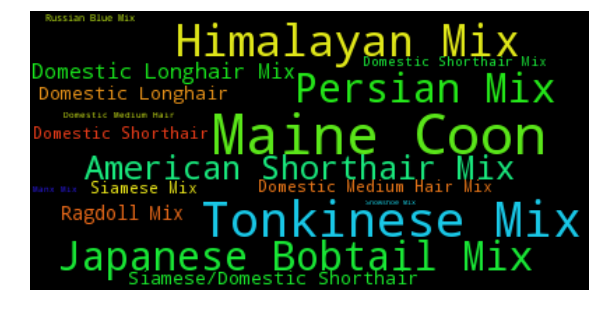

In [15]:

ratios = (rows
        .filter(lambda row: row[ANIMAL_TYPE] == "Cat")
        .map(lambda row: ((row[BREED]), (euthaniased(row),1)))
        .reduceByKey(lambda a,b: (a[0] + b[0], a[1] + b[1]))
        .map(lambda (k,v): (k,(float(v[0])/float(v[1]))))).collect()
wordcloud_from_frequencies(ratios)

# Histogram of Euthanised by Age

In [17]:
agesRDD = rows.filter(euthaniased).map(lambda row: row[AGE]).sortBy(lambda age: age)
ages = agesRDD.collect()
ages[:10]


[u'',
 u'',
 u'0 years',
 u'0 years',
 u'1 month',
 u'1 month',
 u'1 month',
 u'1 month',
 u'1 month',
 u'1 month']

# Euthanised Colours

In [19]:
colour_freq = sql_to_pandas("SELECT Color, count(*) AS Count FROM Animals GROUP BY Color")

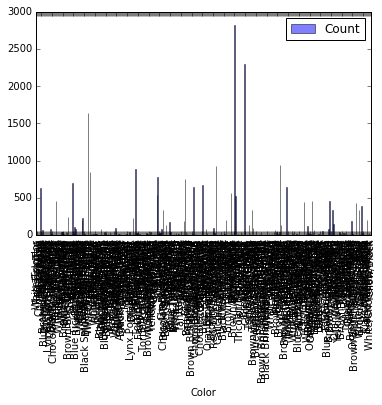

In [20]:
colour_freq.plot(x='Color', y='Count', kind='bar', alpha=0.5)

In [21]:
wordcloud_from_frequencies(rows.map())

ValueError: could not convert string to float: o